
## <center>Sulfuric Acid Condensation to a Particle Population </center>
<center><span style="font-size: 20px;">Aerosol Standards Case 1 </span></center>
<center>Fixed Parameter Case</center>
<center><span style="font-size: 14px;">Created: September 2025 | Revised: MMM YYYY</span></center>

---

This Jupyter notebook has been created under the Aerosol Model Benchmark Repository and Standards (AMBRS) project. 

AMBRS Code and documentation: https://github.com/AMBRS-project  
Authors: https://github.com/orgs/AMBRS-project/people  

The goals of AMBRS Test Case notebooks are to:
- demonstrate aerosol model predictions and behavior under well-defined conditions.
- explore sensitivity of predictions to critical input and model parameters.
- verify suitability of individual aerosol model algorithms.
- characterize aerosol model performance in the context of other contemporary models.
---

### Standard Case 1 - Origin and Details

This standards case was originally explored by Zhang et al. ([1999](https://www.tandfonline.com/doi/abs/10.1080/027868299304039)) for a multimodel comparison study of sulfuric acid condensation and subsequent particle growth. It was more recently implemented to characterize the SSH-Aerosol model developed by Sartelet et al. (2024; [User Guide: Example 8.1.2](https://cerea.enpc.fr/ssh-aerosol/user_manual.pdf)). 

As documented in Sartelet et al. ([2020](https://www.mdpi.com/2073-4433/11/5/525)), sulfate particles are given a tri-modal initial distribution. A sulfuric acid production rate of 9.9 μg m−3 is assumed, characteristic of hazy conditions. Temperature is 283.15 K and the simulation is conducted for 12 hours. 

---


### Configure System

In [1]:
# Import system libraries
import sys
import os
import json

# Include critical paths and import AMBRS library
sys.path.insert(0,'/home/bmurphy/AMBRS/repos/ambrs') #FIXME: Point to local ambrs install path
import ambrs

# Import typical Python packages.
import numpy as np
import scipy.stats as stats
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

### Define Utilities

In [2]:
class const(stats.rv_continuous):
    '''
    Constant "random variable" to fix parameters if perturbation is not desired
    '''
    def __init__(self, c):
        self.c = c
        self.a = c
        self.b = c
        self.loc = 0.
        self.scale = 1.
        self.badvalue = np.nan
    def _parse_args(self, *args, **kwds):
        return args, self.loc, self.scale
    def _ppf(self, q):
        return self.c

def vol_to_num(v, Dgn, sigmag):
    '''
    Convert volume concentration to number concentration based on lognormal mode statistics.
    '''
    # n = 6*m / (np.pi * rho * Dgn**3 * np.exp(4.5 * np.log(sigmag)**2))
    n = v / (Dgn**3 * (np.pi / 6.0) * np.exp(4.5*(np.log(sigmag))**2))
    return n


### Declare Constant Variables

In [3]:
# Simulation parameters
dt = 60. # time step [s]
nsteps = 60 # number of steps

# reference pressure and height
p0 = 101325. # [Pa]
h0 = 1100. # [m]
T0 = 283.15 # [K]
rgas = 1.38065e-23 * 6.02214e26 # [J / K / kmol]
mwdry = 28.966 # [g / mol]

rdair = rgas / mwdry
rwv = rgas / 18.016
# rhodair = p0 / (rdair * T0)

h2so4_form_amt = 5.5 * 1e6 * 1e-18 # [um3 cm-3] -> [m3 m-3]
h2so4_aero_dens = 1.8 * 1e6 * 1e-3 # [g cm-3] -> [kg m-3]
h2so4_molwt = 98.08 * 1e-3 # [g mol-1] -> [kg mol-1]

air_molwt = 28.966 * 1e-3 # [g mol-1] -> [kg mol-1]
air_mol_conc = p0 / (rgas * T0) # [mol m-3]

h2so4_mol_mixrat = ((h2so4_form_amt * h2so4_aero_dens) / h2so4_molwt) / air_mol_conc

timelength_factor = 12.0 * 3600.0 # [s]

h2so4_mol_mixrat_rate = 1e6 * h2so4_mol_mixrat / timelength_factor # [mol mol-1 s-1] -> [ppm s-1]
print(h2so4_mol_mixrat_rate)

h2so4_area_emis = (h2so4_form_amt * h2so4_aero_dens) / h2so4_molwt * h0 / timelength_factor
print(h2so4_area_emis)

### Specify Ensemble Parameters

In [4]:
# Particulate species of interest
particulate_species = [
    "SO4",
    "POM",
    "SOA",
    "BC",
    "DST",
    "NCL",
    "MOM"
]

### Set CAMP Specifications Path

In [5]:
camp_config_path = '/home/bmurphy/AMBRS/repos/ambrs/camp/s1_config'
# Read species names from CAMP definitions
with open(f'{camp_config_path}/species.json', 'r') as f: #FIXME: Point to local camp config path
    spec_def = json.load(f)['camp-data']
f.close()

### Define Aerosol and Gas Chemical Species

In [6]:
# Define AMBRS aerosol species
particles = [
    ambrs.AerosolSpecies( 
        name = p['name'],
        molar_mass = 1e3 * p['molecular weight [kg mol-1]'], # Convert [kg/mol] to [g/mol]
        density = p['density [kg m-3]'],
        ions_in_soln = p['num_ions'],
        hygroscopicity = p['kappa'],
    ) for p in spec_def if p['name'] in particulate_species
]
# Define AMBRS gas species
gases = [
    ambrs.GasSpecies(
        name = g['name'],
        molar_mass = 1e3 * g['molecular weight [kg mol-1]'], # Convert [kg/mol] to [g/mol]
    ) for g in spec_def if 'ION_PAIR' not in g.values() and g['name'] not in particulate_species
]

### Select Aerosol Processes

In [7]:
mam_processes__cond_only = ambrs.AerosolProcesses(
    gas_phase_chemistry = True, # CAMP handles H2SO4 emissions
    coagulation = False,
    condensation = True,
    nucleation = False
)
mam_processes__coag_only = ambrs.AerosolProcesses(
    gas_phase_chemistry = False,
    coagulation = True,
    condensation = False,
    nucleation = False
)
mam_processes__cond_and_coag = ambrs.AerosolProcesses(
    gas_phase_chemistry = True, # CAMP handles H2SO4 emissions
    coagulation = True,
    condensation = True,
    nucleation = False
)

pmc_processes__cond_only = ambrs.AerosolProcesses(
    gas_phase_chemistry = True, # Condensation handled by CAMP
    coagulation = False,
    condensation = False, # This means cloud condensation
    nucleation = False
)
pmc_processes__coag_only = ambrs.AerosolProcesses(
    gas_phase_chemistry = False, # Condensation handled by CAMP
    coagulation = True,
    condensation = False,
    nucleation = False
)
pmc_processes__cond_and_coag = ambrs.AerosolProcesses(
    gas_phase_chemistry = True, # Condensation handled by CAMP
    coagulation = True,
    condensation = False, # This means cloud condensation
    nucleation = False
)

### Specify Test Case Conditions

In [8]:
# Initial size distribution parameters hard-coded in MAM4, do not match Seigneur et al. (1986)
DgnAccum_hazy = 0.24e-6
DgnAitken_hazy = 0.044e-6
DgnCoarse_hazy = 6.0e-6
sigmagAccum_hazy = 1.8
sigmagAitken_hazy = 1.2
sigmagCoarse_hazy = 2.2

DgnAccum_urban = 0.32e-6
DgnAitken_urban = 0.038e-6
DgnCoarse_urban = 5.7e-6
sigmagAccum_urban = 2.16
sigmagAitken_urban = 1.8
sigmagCoarse_urban = 2.21

# Initial number concentrations derived from volume concentrations and corresponding size parameters
# from Seignuer et al. (1986)
numAccum_hazy = vol_to_num(5.8e-12, DgnAccum_hazy, sigmagAccum_hazy)
numAitken_hazy = vol_to_num(0.09e-12, DgnAitken_hazy, sigmagAitken_hazy)
numCoarse_hazy = vol_to_num(25.9e-12, DgnCoarse_hazy, sigmagCoarse_hazy)

numAccum_urban = vol_to_num(38.4e-12, DgnAccum_urban, sigmagAccum_urban)
numAitken_urban = vol_to_num(0.63e-12, DgnAitken_urban, sigmagAitken_urban)
numCoarse_urban = vol_to_num(30.8e-12, DgnCoarse_urban, sigmagCoarse_urban)

T0 = 283.15 # [K]

### Specify Perturbed Parameter Ensemble

In [9]:
spec_hazy = ambrs.EnsembleSpecification(
    name = "ppe_spec_hazy",
    aerosols = tuple(particles),
    gases = tuple(gases),
    size = ambrs.AerosolModalSizeDistribution(
        modes = [
            ambrs.AerosolModeDistribution(
                name = "accumulation",
                species = particles,
                number = const(numAccum_hazy),
                geom_mean_diam = const(DgnAccum_hazy),
                log10_geom_std_dev = const(np.log10(sigmagAccum_hazy)),
                mass_fractions = [const(1.) if p.name in ['SO4'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "aitken",
                species = particles,
                number = const(numAitken_hazy),
                geom_mean_diam = const(DgnAitken_hazy),
                log10_geom_std_dev = const(np.log10(sigmagAitken_hazy)),
                mass_fractions = [const(1.) if p.name in ['SO4'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "coarse",
                species = particles,
                number = const(numCoarse_hazy),
                geom_mean_diam = const(DgnCoarse_hazy),
                log10_geom_std_dev = const(np.log10(sigmagCoarse_hazy)),
                mass_fractions = [const(1.) if p.name in ['SO4'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                # This mode is retained for MAM4 compatibility but is zeroed out
                name = "primary_carbon",
                species = particles,
                number = const(0.),
                geom_mean_diam = const(0.05e-6),
                log10_geom_std_dev = const(np.log10(1.6)),
                mass_fractions = [const(1.) if p.name in ['POM'] else const(0.) for p in particles]
            ),
        ]
    ),
    gas_concs = tuple([const(1e-3) if g.name=='H2SO4' else const(0.) for g in gases]),
    gas_emissions = [(i*dt, {g.name:0.0 for g in gases} | {'rate':1.0, 'H2SO4':2.5701808047852094e-09}) \
                     for i in range(nsteps)],
    flux = const(0.),
    relative_humidity = const(0.6), # from Sartelet et al. (2020) coag+cond+nuc
    temperature = const(T0),
    pressure = const(p0),
    height = h0,
)
spec_urban = ambrs.EnsembleSpecification(
    name = "ppe_spec_urban",
    aerosols = tuple(particles),
    gases = tuple(gases),
    size = ambrs.AerosolModalSizeDistribution(
        modes = [
            ambrs.AerosolModeDistribution(
                name = "accumulation",
                species = particles,
                number = const(numAccum_urban),
                geom_mean_diam = const(DgnAccum_urban),
                log10_geom_std_dev = const(np.log10(sigmagAccum_urban)),
                mass_fractions = [const(1.) if p.name in ['SO4'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "aitken",
                species = particles,
                number = const(numAitken_urban),
                geom_mean_diam = const(DgnAitken_urban),
                log10_geom_std_dev = const(np.log10(sigmagAitken_urban)),
                mass_fractions = [const(1.) if p.name in ['SO4'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "coarse",
                species = particles,
                number = const(numCoarse_urban),
                geom_mean_diam = const(DgnCoarse_urban),
                log10_geom_std_dev = const(np.log10(sigmagCoarse_urban)),
                mass_fractions = [const(1.) if p.name in ['SO4'] else const(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                # This mode is retained for MAM4 compatibility but is zeroed out
                name = "primary_carbon",
                species = particles,
                number = const(0.),
                geom_mean_diam = const(0.05e-6),
                log10_geom_std_dev = const(np.log10(1.6)),
                mass_fractions = [const(1.) if p.name in ['POM'] else const(0.) for p in particles]
            ),
        ]
    ),
    gas_concs = tuple([const(1e-3) if g.name=='H2SO4' else const(0.) for g in gases]),
    gas_emissions = [(i*dt, {g.name:0.0 for g in gases} | {'rate':1.0, 'H2SO4':2.5701808047852094e-09}) \
                     for i in range(nsteps)],
    flux = const(0.),
    relative_humidity = const(0.6), # from Sartelet et al. (2020) coag+cond+nuc
    temperature = const(T0),
    pressure = const(p0),
    height = h0,
)

### Run Ensemble Simulations

In [31]:
n = 1
ensemble_hazy = ambrs.lhs(specification=spec_hazy, n=n)
ensemble_urban = ambrs.lhs(specification=spec_urban, n=n)
n_part = 1000

root = '/home/bmurphy/AMBRS/local_tests/s1_fpc_h2so4cond/output'
for ensemble,condition in zip([ensemble_hazy, ensemble_urban],['hazy','urban']):
    for processes,label in zip(
        [mam_processes__cond_only], #, mam_processes__coag_only, mam_processes__cond_and_coag],
        ['cond_only'] #,'coag_only','cond_and_coag']
        ):
        mam4 = ambrs.mam4.AerosolModel(
            processes = processes,
            camp_config = f'{camp_config_path}/mam4_config.json',
            camp_mech = 'MAM4_H2SO4_emission',
        )
        mam4_inputs = mam4.create_inputs(
            ensemble = ensemble,
            dt = dt,
            nstep = nsteps,
        )
        mam4_runner = ambrs.PoolRunner(
            model = mam4,
            executable = '/home/bmurphy/AMBRS/ambrs_builds/bin/mam4',
            root = f'{root}/{condition}/{label}/mam',
            num_processes = 1,
        )
        mam_outputs = mam4_runner.run(mam4_inputs)
    
    for processes,label in zip(
        [mam_processes__cond_only], #, mam_processes__coag_only, mam_processes__cond_and_coag],
        ['cond_only'] #,'coag_only','cond_and_coag']
        ):
        partmc = ambrs.partmc.AerosolModel(
            processes = processes,
            n_part = n_part,
            camp_config = f'{camp_config_path}/partmc_config.json'
        )
        partmc_inputs = partmc.create_inputs(
            ensemble = ensemble,
            dt = dt,
            nstep = nsteps,
        )
        partmc_runner = ambrs.PoolRunner(
            model = partmc,
            executable = '/home/bmurphy/AMBRS/ambrs_builds/bin/partmc',
            root = f'{root}/{condition}/{label}/pmc',
            num_processes = 1,
        )
        partmc_outputs = partmc_runner.run(partmc_inputs)


[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[AerosolSpecies(name='SO4', molar_mass=115.10734000000001, density=1770.0, ions_in_soln=2, hygroscopicity=0.0, aliases=None), AerosolSpecies(name='POM', molar_mass=12.011000000000001, density=1000.0, ions_in_soln=0, hygroscopicity=0.01, aliases=None), AerosolSpecies(name='SOA', molar_mass=12.011000000000001, density=1000.0, ions_in_soln=0, hygroscopicity=0.14, aliases=None), AerosolSpecies(name='BC', molar_mass=12.011000000000001, density=1700.0, ions_in_soln=0, hygroscopicity=1e-10, aliases=None), AerosolSpecies(name='DST', molar_mass=135.064039, density=2600.0, ions_in_soln=0, hygroscopicity=0.068, aliases=None), AerosolSpecies(name='NCL', molar_mass=58.442468, density=1900.0, ions_in_soln=0, hygroscopicity=1

mam4: one or more existing scenario directories found. Overwriting contents...


! generated by ambrs.mam4.AerosolModel.write_input_files
&time_input
  mam_dt         = 60.0,
  mam_nstep      = 60,
/
&cntl_input
  mdo_gaschem    = 1,
  mdo_gasaerexch = 1,
  mdo_rename     = 1,
  mdo_newnuc     = 0,
  mdo_coag       = 0,
/
&met_input
  temp           = 283.15,
  press          = 101325.0,
  RH_CLEA        = 0.6,
/
&chem_input
  numc1          = 169273767.85418934, ! unit: #/m3
  numc2          = 1737488110.6000855,
  numc3          = 13960.848584965877,
  numc4          = 0.0,
  !
  ! mfABCx: mass fraction of species ABC in mode x.
  ! 
  ! The mass fraction of mom is calculated by
  ! 1 - sum(mfABCx). If sum(mfABCx) > 1, an error
  ! is issued by the test driver. number of species
  ! ABC in each mode x comes from the MAM4 with mom.
  ! 
  mfso41         = 1.0,
  mfpom1         = 0.0,
  mfsoa1         = 0.0,
  mfbc1          = 0.0,
  mfdst1         = 0.0,
  mfncl1         = 0.0,
  mfso42         = 1.0,
  mfsoa2         = 0.0,
  mfncl2         = 0.0,
  mfdst3       

partmc: one or more existing scenario directories found. Overwriting contents...
mam4: one or more existing scenario directories found. Overwriting contents...


[AerosolSpecies(name='SO4', molar_mass=115.10734000000001, density=1770.0, ions_in_soln=2, hygroscopicity=0.0, aliases=None), AerosolSpecies(name='POM', molar_mass=12.011000000000001, density=1000.0, ions_in_soln=0, hygroscopicity=0.01, aliases=None), AerosolSpecies(name='SOA', molar_mass=12.011000000000001, density=1000.0, ions_in_soln=0, hygroscopicity=0.14, aliases=None), AerosolSpecies(name='BC', molar_mass=12.011000000000001, density=1700.0, ions_in_soln=0, hygroscopicity=1e-10, aliases=None), AerosolSpecies(name='DST', molar_mass=135.064039, density=2600.0, ions_in_soln=0, hygroscopicity=0.068, aliases=None), AerosolSpecies(name='NCL', molar_mass=58.442468, density=1900.0, ions_in_soln=0, hygroscopicity=1.16, aliases=None), AerosolSpecies(name='MOM', molar_mass=250092.672, density=1601.0, ions_in_soln=0, hygroscopicity=0.1, aliases=None)]
[AerosolSpecies(name='SO4', molar_mass=115.10734000000001, density=1770.0, ions_in_soln=2, hygroscopicity=0.0, aliases=None), AerosolSpecies(na

partmc: one or more existing scenario directories found. Overwriting contents...


### Open Output Files and Load Data

In [32]:
mam = xr.open_dataset(
    '/home/bmurphy/AMBRS/local_tests/s1_fpc_h2so4cond/output/hazy/cond_only/mam/1/mam_output.nc'
)
pmc = xr.open_mfdataset(
    '/home/bmurphy/AMBRS/local_tests/s1_fpc_h2so4cond/output/hazy/cond_only/pmc/1/out/*.nc',
    combine='nested',
    concat_dim='nsteps'
)

### Make figures of Sulfate increase and Sulfuric Acid decrease

In [ ]:
so4_index = 0
so4_pmc = 1e9 * (pmc.isel(aero_species=so4_index).aero_particle_mass * \
                 pmc.isel(aero_species=so4_index).aero_num_conc).sum('aero_particle')
h2so4_pmc = pmc.isel(gas_species=2).gas_mixing_ratio
so4_aer__ug_m3 = 1e9*mam.so4_aer.sum('mode')*(air_mol_conc*air_molwt)


Text(0.5, 0, 'Time [min]')

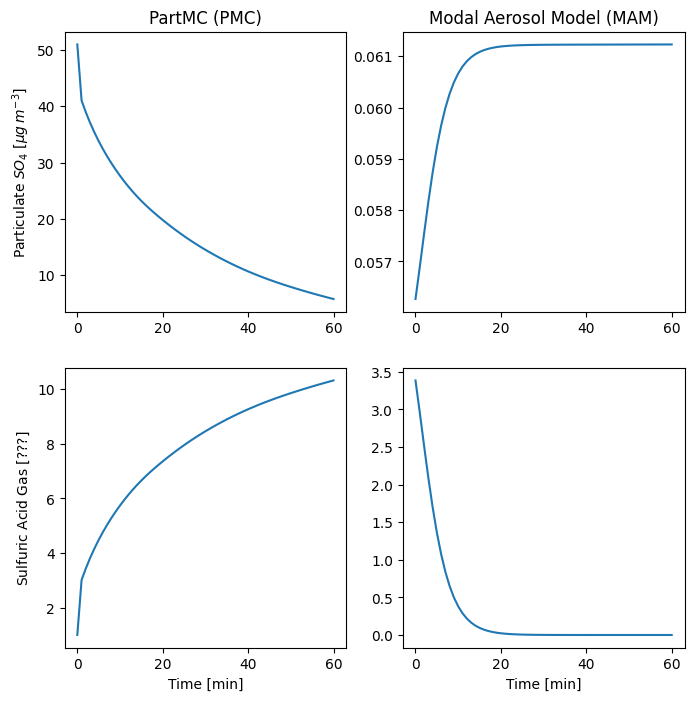

In [51]:
cfig, ax1 = plt.subplots( 2,2, figsize=(8,8))
ax1[0,0].plot(np.arange(61), so4_pmc)
ax1[0,0].set_ylabel(r'Particulate $SO_4$ $[\mu g \: m^{-3}]$')
ax1[0,0].set_title('PartMC (PMC)')
ax1[0,1].plot(np.arange(61), so4_aer__ug_m3)
ax1[0,1].set_title('Modal Aerosol Model (MAM)')
ax1[1,0].plot(np.arange(61), h2so4_pmc)
ax1[1,0].set_xlabel('Time [min]')
ax1[1,0].set_ylabel('Sulfuric Acid Gas $[???]$')
ax1[1,1].plot(np.arange(61), 1e9*mam.h2so4_gas)
ax1[1,1].set_xlabel('Time [min]')

# plt.plot(np.arange(61), h2so4_pmc)

In [42]:
ax1[0,0]

<Axes: >

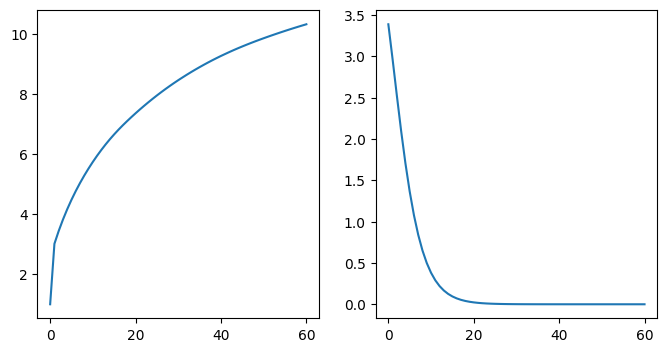

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8,4))


---
### End Standard Test 1